# DuckDuckGo Tool 테스트
duckduckgo_tool의 기본 동작, max_results 옵션, LangGraph agent 연동까지 순서대로 테스트합니다.

## 0. load env

In [1]:

import os
import sys

from dotenv import load_dotenv, find_dotenv

# Load environment variables
dotenv_path = find_dotenv()
print(f"Target .env path: {dotenv_path}")
loaded = load_dotenv(dotenv_path, override=True)
print(f"Loading successful: {loaded}")

# Add project root to path
sys.path.append(os.path.abspath('..'))


Target .env path: /Users/kimjunghyeon/Desktop/workspace/ai-agent/.env
Loading successful: True


## 1. 기본 검색 테스트

In [2]:
from app.agents.tools.duckduckgo import duckduckgo_tool

query = "2026 AI 전망"
result = duckduckgo_tool.invoke({"query": "LangGraph multi-agent 2024"})
print(result)

Impersonate 'chrome_119' does not exist, using 'random'


snippet: When viewed in this way, the independent agent nodes become the states, and how those agents are connected is the transition matrices. Since a state machine can be viewed as a labeled, directed graph , we will think of these things in the same way. Benefits of multi - agent designs., title: LangGraph : Multi - Agent Workflows, link: https://blog.langchain.com/langgraph-multi-agent-workflows/, snippet: So everyone in LLM space knows by now LangChain as a tool that helps orchestration of LLM calls in an application. And LangGraph is a step forward and orchestrates multiple agents . "LangChain is a framework to build with LLMs by chaining interoperable components., title: LangGraph , multi - agent applications with LLMs, link: https://www.linkedin.com/pulse/langgraph-multi-agent-applications-llms-natalia-konstantinova-ck4if, snippet: Today, software development stands at the vanguard of this technological revolution. LLM-based agents are increasingly employed to automate numerous

## 2. max_results 옵션 테스트

In [3]:
# max_results = 1
result_1 = duckduckgo_tool.invoke({"query": query, "max_results": 1})
print("=== max_results=1 ===")
print(result_1)
print(f"\n글자수: {len(result_1)}")

=== max_results=1 ===
snippet: 삼성SDS, ‘ 2026 년 5대 사이버 보안 위협’ 발표… AI 기반 모니터링·자동 차단 전환 강조 AI 악용·랜섬웨어 4중 갈취·클라우드 설정 오류·피싱·데이터 보안 위협 선정. SNS 기사보내기., title: 2026 년 기업을 위협하는 AI 에이전트·랜섬웨어·클라우드 설정 오류, link: https://www.gttkorea.com/news/articleView.html?idxno=24532

글자수: 235


In [4]:
# max_results = 10
result_10 = duckduckgo_tool.invoke({"query": query, "max_results": 10})
print("=== max_results=10 ===")
print(result_10)
print(f"\n글자수: {len(result_10)}")

=== max_results=10 ===
snippet: Expert AI predictions for 2026 reveal that AI will become more than a fast tool but more human-centric, requiring soft skills, teammate collaboration and AI literacy., title: 10 AI Predictions For 2026: Top Experts Share New Trends - Forbes, link: https://www.forbes.com/sites/bryanrobinson/2025/12/04/10-ai-predictions-for-2026-top-experts-share-new-trends/, snippet: 2026 년 AI 기술 현황과 전망 — '대세'는 맞지만, 승부는 운영과 검증에서 갈린다 결론: 2026 년 AI 는 "도입"이 아니라 운영 (거버넌스·보안·품질·ROI) 이 경쟁력인 단계로 넘어갔고, 전망 역시 모델 성능보다 업무 재설계·에이전트형 자동화·규제 준수·데이터 품질 에서 성패가 갈린다., title: 2026년 AI 기술 현황과 전망 - aclip.tistory.com, link: https://aclip.tistory.com/entry/ai-technology-status-outlook-2026, snippet: Seven AI trends to watch in 2026 will make AI a true partner — boosting teamwork, security, research momentum and infrastructure efficiency., title: What's next in AI: 7 trends to watch in 2026 - news.microsoft.com, link: https://news.microsoft.com/source/features/ai/whats-next-in-ai-7-trends-to-wat

## 3. LangGraph Agent 연동 테스트

In [7]:
from typing import Annotated, TypedDict

from langchain_core.messages import AnyMessage, HumanMessage
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition

from app.agents.core.agent_factory import create_agent, create_tool_node_with_fallback
from app.agents.tools.duckduckgo import duckduckgo_tool


# ── State ────────────────────────────────────────────────────────────────────
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# ── Agent & Tool Node ────────────────────────────────────────────────────────
tools = [duckduckgo_tool]

agent = create_agent(
    tools=tools,
    system_prompt="당신은 웹 검색 어시스턴트입니다. DuckDuckGo로 최신 정보를 검색해 답변합니다.",
)

tool_node = create_tool_node_with_fallback(tools)

# ── Graph ────────────────────────────────────────────────────────────────────
workflow = StateGraph(State)
workflow.add_node("agent", agent)
workflow.add_node("tools", tool_node)
workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "tools",
        END: END
    }
)
workflow.add_edge("tools", "agent")

app = workflow.compile()
print("✅ Graph 컴파일 완료")

# ── 실행 ─────────────────────────────────────────────────────────────────────
query = "LangGraph multi-agent 2026 최신 동향 검색해줘"  # 검색 필요 질문
# query = "서울 수도는??" # 검색 불필요 질문
async for chunk in app.astream(
        {"messages": [HumanMessage(content=query)]},
        stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

✅ Graph 컴파일 완료
================================ Human Message =================================

LangGraph multi-agent 2026 최신 동향 검색해줘
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_tool (call_ICkpfPHtxUsXyXudtfnMs8ma)
 Call ID: call_ICkpfPHtxUsXyXudtfnMs8ma
  Args:
    query: LangGraph multi-agent 2026 최신 동향
    max_results: 5
================================= Tool Message =================================
Name: duckduckgo_tool

snippet: Agentic AI Roadmap 2026 : From Multi-Agent Systems to Enterprise Orchestration A strategic blueprint for creators, founders, and executives to deploy agentic AI systems in 2026 . Updated with LangGraph , CrewAI, MCP protocol, and OCI GenAI patterns., title: Agentic AI Roadmap 2026: From Multi-Agent Systems to Enterprise ..., link: https://www.frankx.ai/blog/agentic-ai-roadmap-2026, snippet: Build advanced AI agents with LangGraph . Learn to manage state, loops, and multi-agent workflows for re

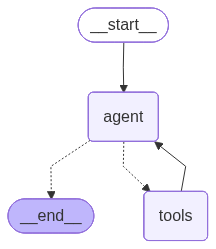

In [7]:
# Graph 시각화
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())